## High Level Computer Vision 
### Exercise 2: Deep Neural Networks and Backpropagation

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from resources.gradient_check import eval_numerical_gradient
from resources.data_utils import get_CIFAR10_data
from resources.vis_utils import visualize_grid


Deep neural networks have shown staggering performances in various learning tasks, including computer vision, natural language processing, and sound processing. They have made the model design more flexible by enabling end-to-end training.

In this exercise, we get to have a first hands-on experience with neural network training. Many frameworks (e.g., PyTorch, Tensorflow, Caffe) allow easy usage of deep neural networks without precise knowledge of the inner workings of backpropagation and gradient descent algorithms. While these are very useful tools, it is important to get a good understanding of how to implement basic network training from scratch before using these libraries to speed up the process. For this purpose, we will implement a simple two-layer neural network and its training algorithm based on back-propagation using only basic matrix operations in questions 1 to 3. In question 4, we will use a popular deep learning library, PyTorch, to do the same and understand the advantages offered by using such tools.

As a benchmark to test our models, we consider an image classification task using the widely used CIFAR-10 dataset. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to code and train a parametrized model for classifying those images. This involves

- Implementing the feedforward model (Question 1).
- Implementing the backpropagation algorithm (gradient computation) (Question 2).
- Training the model using stochastic gradient descent and improving the model training with better hyper-parameters (Question 3).
- Using the PyTorch Library to implement the above and experiment with deeper networks (Question 4).

A note on notation: Throughout the exercise, notation $v_i$ is used to denote the $i$-th element of vector $v$.

### Question 1: Implementing the feedforward model (10 points)

In this question, we will implement a two-layered neural network architecture and the loss function to train it.

<img src="./resources/fig1.png" width="900" align=left>

**Model architecture.** Our architecture is shown in Fig.1. It has an input layer and two model layers – a hidden and an output layer. We start with randomly generated toy inputs of four dimensions and the number of classes K = 3 to build our model in Q1 and Q2, and in Q3 use images from the CIFAR-10 dataset to test our model on a real-world task. Hence input layer is 4-dimensional for now.

In the hidden layer, there are ten units. The input layer and the hidden
layer are connected via linear weighting matrix $W^{(1)}\in\mathbb{R}^{10\times
4}$ and the bias term $b^{(1)}\in\mathbb{R}^{10}$. The parameters $W^{(1)}$
and $b^{(1)}$ are to be learnt later on. A linear operation is performed,
$W^{(1)}x+b^{(1)}$, resulting in a 10 dimensional vector $z^{(2)}$. It is then
followed by a relu non-linear activation $\phi$, applied element-wise on each
unit, resulting in the activations $a^{(2)} = \phi(z^{(2)})$. Relu function has
the following form:
\begin{equation}
\label{eq:sigmoid}
\phi(u) =  \begin{cases}
      u, & \text{if}\ u\geq0 \\
      0, & \text{if}\ u <0
    \end{cases}
\end{equation}

A similar linear operation is performed on $a^{(2)}$, resulting in $z^{(3)}=W^{(2)}a^{(2)}+b^{(2)}$, where $W^{(2)}\in\mathbb{R}^{3\times 10}$ and $b^{(2)}\in\mathbb{R}^{3}$; it is followed by the softmax activation to result in $a^{(3)}=\psi(z^{(3)})$. The softmax function is defined by:
\begin{equation}
\psi(u)_i =  \frac{\exp^{u_i}}{\sum_j{\exp^{u_j}}} 
\end{equation}

The final functional form of our model is thus defined by
\begin{align}
\label{eq:feedforward-model-start}
a^{(1)} & = x \\\
z^{(2)} & = W^{(1)}a^{(1)}+b^{(1)} \\
a^{(2)} & = \phi(z^{(2)}) \\
z^{(3)} & = W^{(2)}a^{(2)}+b^{(2)} \\
\label{eq:feedforward-model-end}
f_\theta(x) := a^{(3)} & = \psi(z^{(3)}),
\end{align}
which takes a flattened 4 dimensional vector as input and outputs a $3$ dimensional vector, each entry in the output $f_k(x)$ representing the probability of image $x$ corresponding to the class $k$. We summarily indicate all the network parameters by $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.

**Implementation.** We are now ready to implement the feedforward neural network.

a) Implement the feedforward model. Verify that the scores you generate for the toy inputs match the correct scores. (5 points)

In [3]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def forward(self, X):
        """
        Compute the final outputs for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        A matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        z1 = np.matmul(X, W1) + b1

        a1 = np.maximum(z1, 0)

        z2 = np.matmul(a1, W2) + b2
        
        exp_z2 = np.exp(z2)

        scores = exp_z2/np.sum(exp_z2, axis=1).reshape(X.shape[0],1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
         
        # If the targets are not given then jump out, we're done
        return scores       

In [4]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

scores = net.forward(X)
print('Your scores:')
print(scores)
print()
print('Correct scores:')
correct_scores = np.asarray([
 [0.36446210, 0.22911264, 0.40642526],
 [0.47590629, 0.17217039, 0.35192332],
 [0.43035767, 0.26164229, 0.30800004],
 [0.41583127, 0.29832280, 0.28584593],
 [0.36328815, 0.32279939, 0.31391246]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

assert math.isclose(np.sum(np.abs(scores - correct_scores)), 0,  abs_tol=1e-6)


Your scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Correct scores:
[[0.3644621  0.22911264 0.40642526]
 [0.47590629 0.17217039 0.35192332]
 [0.43035767 0.26164229 0.30800004]
 [0.41583127 0.2983228  0.28584593]
 [0.36328815 0.32279939 0.31391246]]

Difference between your scores and correct scores:
2.917341163088949e-08


b) We later guide the neural network parameters
$\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$ to fit the given data and label
pairs. We do so by minimising the loss function. A popular choice of the loss
function for training neural networks for multi-class classification is the
cross-entropy loss. For a single input sample $x_i$, with label $y_i$, the loss
function is defined as:
\begin{align}
J(\theta, x_i, y_i) &= -\log{P(Y=y_i,X=x_i)} \\
                    &= -\log{f_\theta(x_i)_{y_i}} \\
                    &= -\log{\psi(z^{(3)})_{y_i}} \\
J(\theta, x_i, y_i) &= -\log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum^K_j{\exp^{z^{(3)}_j}}}\right]
\label{eq:log-loss-softmax}
\end{align}

Averaging over the whole training set, we get 
\begin{equation}
\label{eq:log-loss-softmax-empirical}
J(\theta,\{x_i,y_i\}_{i=1}^{N}) = \frac{1}{N} \sum_{i=1}^N 
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right],
\end{equation}
where $K$ is the number of classes. Note that if the model has perfectly fitted
to the data (\emph{i.e.} $f_\theta^k(x_i)=1$ whenever $x_i$ belongs to class $k$ and 0
otherwise), then $J$ attains the minimum of $0$. 


Apart from trying to correctly predict the label, we have to prevent
overfitting the model to the current training data.  This is done by encoding
our prior belief that the correct model should be simple (Occam's razor); we
add an $L_2$ regularisation term over the model parameters $\theta$.
Specifically, the loss function is defined by:
\begin{equation}
\label{eq:log-loss-empirical-regularised}
\tilde{J}(\theta) = \frac{1}{N} \sum_{i=1}^N
-log\left[ \frac{\exp^{z^{(3)}_{y_i}}}{\sum_j{\exp^{z^{(3)}_j}}}\right]
+\lambda \left(||W^{(1)}||_2^2 + ||W^{(2)}||_2^2 \right),
\end{equation}
where $||\cdot||_2^2$ is the squared $L_2$ norm. For example,
\begin{equation}
\label{eq:L2-term}
||W^{(1)}||_2^2 = 
\sum_{p=1}^{10} \sum_{q=1}^{4} W_{pq}^{(1)2}
\end{equation}
By changing the value of $\lambda$ it is possible to give weights to your prior belief on the degree of simplicity (regularity) of the true model. 

Implement the final loss function and let it return the loss value. Verify the code by
running and matching the output cost $1.30378789133$. (5 points)

In [5]:
class TwoLayerNetv2(TwoLayerNet):
    def compute_loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        scores = self.forward(X)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        
        if y is None:
            return scores

        # Compute the loss
        loss = 0.
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        for i in range(X.shape[0]):
            loss += -np.log(scores[i, y[i]])
        
        loss = loss/X.shape[0] + reg*(np.sum(W1**2) + np.sum(W2**2))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss

In [6]:
# Compute loss in the same function
def init_toy_model_v2():
    np.random.seed(0)
    return TwoLayerNetv2(input_size, hidden_size, num_classes, std=1e-1)

net_v2 = init_toy_model_v2()
loss = net_v2.compute_loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

assert math.isclose(np.sum(np.abs(loss - correct_loss)), 0,  abs_tol=1e-6)

Difference between your loss and correct loss:
1.794120407794253e-13


### Question 2: Backpropagation (15 points)

We train the model by solving
\begin{equation}
\label{eq:train-main}
\underset{\theta}{\min} \,\,  \tilde{J}(\theta)
\end{equation}
via stochastic gradient descent. Therefore, We need an efficient computation of the gradients $\nabla_\theta \tilde{J}(\theta)$. We use backpropagation of top layer error signals to the parameters $\theta$ at different layers.

In this question, you will be required to implement the backpropagation algorithm yourself from pseudocode. We will give a high-level description of what is happening in each line.

For those who are interested in the robust derivation of the algorithm, we include the optional exercise on the derivation of the backpropagation algorithm. A piece of prior knowledge of standard vector calculus, including the chain rule, would be helpful. 


**Backpropagation.** The backpropagation algorithm is simply a sequential application of the chain rule. It is applicable to any (sub-) differentiable model that is a composition of simple building blocks. In this exercise, we focus on the architecture with stacked layers of linear transformation + relu non-linear activation.

The intuition behind the backpropagation algorithm is as follows. Given a training example $(x, y)$, we first run the feedforward to compute all the activations throughout the network, including the output value of the model $f_\theta(x)$ and the loss $J$. Then, for each parameter in the model, we want to compute the effect that parameter has on the loss. This is done by computing the derivatives of the loss w.r.t for each model parameter.

The backpropagation algorithm is performed from the top of the network (loss layer) to the bottom. It sequentially computes the gradient of the loss function with respect to each layer's activations and parameters.

Let’s start by deriving the gradients of the un-regularized loss function w.r.t final layer activations $z^{(3)}$. We will then use this in the chain rule to compute analytical expressions for gradients of all the model parameters.

(a) Verify that the loss function (in Q1) has the gradient w.r.t $z^{(3)}$ as below.
\begin{equation}
\frac{\partial J}{\partial z^{(3)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) = \frac{1}{N}\left(\psi(z^{(3)}) - \Delta\right), 
\end{equation}
where $\Delta$ is a matrix of $N\times K$ dimensions with 
\begin{equation}
        \Delta_{ij} = \begin{cases}
        1, & \text{if}\ y_i =j \\
                0, & \text{otherwise}
\end{cases}
\end{equation}
(please write your answer in the block below, 2 points)

b) To compute the effect of the weight matrix $W^{(2)}$ on the loss (in Q1) incurred by the network, we compute the
partial derivatives of the loss function with respect to $W^{2}$.  This is done
by applying the chain rule. Verify that the partial derivative of the loss
w.r.t $W^{(2)}$ is  
\begin{align}
\label{eq:grad-loss-multi}
\frac{\partial J}{\partial W^{(2)}}\left(\{x_i,y_i\}_{i=1}^{N}\right) &= \frac{\partial J}{\partial z^{(3)}} \cdot \frac{\partial z^{(3)}}{\partial W^{(2)}} \\
&= \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'}
\end{align}

Similary, verify that the regularized loss has the derivatives

\begin{equation}
\frac{\partial \tilde{J}}{\partial W^{(2)}} = \frac{1}{N} (\psi(z^{(3)}) - \Delta) a^{(2)'} + 2\lambda W^{(2)}
\end{equation}

(please write your answer in the block below, 2 points)

c) We can repeatedly apply chain rule as discussed above to obtain the derivatives of the loss with respect to all the parameters of the model $\theta=(W^{(1)},b^{(1)},W^{(2)},b^{(2)})$.
Dervive the expressions for the derivatives of the regularized loss (in Q1) w.r.t $W^{(1)}$, $b^{(1)}$, $b^{(2)}$ now.
(please write your answer in the block below, 6 points)

d) Using the expressions you obtained for the derivatives of the loss w.r.t model
parameters, implement the back-propagation algorithm. Run the code and verify that the
gradients you obtained are correct using numerical gradients (already
implemented in the code). The maximum relative error between the gradients you
compute and the numerical gradients should be less than 1e-8 for all parameters.
(5 points)

In [7]:
class TwoLayerNetv3(TwoLayerNetv2):
    def back_propagation(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D= X.shape


        # Compute the forward pass
        scores = 0.
        #############################################################################
        # TODO: Perform the forward pass, computing the class probabilities for the #
        # input. Store the result in the scores variable, which should be an array  #
        # of shape (N, C).                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****             
        scores = self.forward(X)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = 0.
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        loss = self.compute_loss(X, y, reg =0.05)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        z2 = np.matmul(X, W1) + b1 # N x 10
        a2 = np.maximum(z2, 0) # N x 10
        z3 = np.matmul(a2, W2) + b2
        
        # calculating hot encoding of y delta N x num_classes
        delta = np.zeros((N, num_classes))
        for i, label in enumerate(y):
            delta[i, label] = 1
        
        # calculating the gradients
        del2  = 1/ N * (scores - delta)
        grads['b2'] = del2.sum(axis=0)
        grads['W2'] = np.dot(a2.T, del2) + 2*reg*W2    #dimension = 10 x 3
        del_a2 = []

        for row in a2:
            del_a2.append([1 if ele > 0 else 0 for ele in row])
        del1 = 1/ N * ((scores - delta).dot(W2.T))*del_a2
        grads['b1'] = del1.sum(axis=0) 
        grads['W1'] = np.dot(del1.T, X).T + 2*reg*W1

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

In [8]:
# Compute the gradient
def init_toy_model_v3():
    np.random.seed(0)
    return TwoLayerNetv3(input_size, hidden_size, num_classes, std=1e-1)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

net_v3 = init_toy_model_v3()

loss, grads = net_v3.back_propagation(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net_v3.back_propagation(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net_v3.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 3.865049e-11
W2 max relative error: 3.440708e-09
b1 max relative error: 2.738422e-09
W1 max relative error: 3.669858e-09


### Question 3: Stochastic gradient descent training (10 points)

We have implemented the backpropagation algorithm for computing the parameter gradients and have verified that it indeed gives the correct gradient. We are now ready to train the network. We solve Eq.15 with the stochastic gradient descent.

Typically neural networks are large and are trained with millions of data
points. It is thus often infeasible to compute the gradient $\nabla_\theta
\tilde{J}(\theta)$ that requires the accumulation of the gradient over the
entire training set. Stochastic gradient descent addresses this problem by
simply accumulating the gradient over a small random subset of the training
samples (minibatch) at each iteration. Specifically, the algorithm is as
follows,

<img src="./resources/alg1.png" width="900" align=left>

where the gradient $\nabla_\theta \tilde{J}(\theta,\{(X^\prime_j,y^\prime_j)\}_{j=1}^B)$ is computed only on the current randomly sampled batch.

Intuitively, $v = -\nabla_\theta \tilde{J}(\theta^{(t-1)})$ gives the direction
to which the loss $\tilde{J}$ decreases the most (locally), and therefore we
follow that direction by updating the parameters towards that direction
$\theta^{(t)} = \theta^{(t-1)} + v$. 

a) Implement the stochastic gradient descent algorithm and run the training on the toy data. Your model
should be able to  obtain loss <= 0.02 on the training set and the training
curve should look similar to the one shown in figure 2.

<img src="./resources/fig2.png" width="500" align=left>

In [9]:
import random
from random import randint
class TwoLayerNetv4(TwoLayerNetv3):
    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = X
            y_batch = y

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #random_choice =[randint(0, num_train -1) for _ in range(batch_size)]
            idx = np.random.choice(num_train,batch_size,replace=True)
            X_batch = X[idx]
            y_batch = y[idx]
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Compute loss and gradients using the current minibatch
            loss, grads = self.back_propagation(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            self.params['W1'] -= learning_rate*grads['W1']
            self.params['b1'] -= learning_rate*grads['b1']
            self.params['W2'] -= learning_rate*grads['W2']
            self.params['b2'] -= learning_rate*grads['b2']

                
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }
    
    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        scores = self.forward(X)
        y_pred = scores.argmax(axis=1)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

Final training loss:  0.12598360903789552


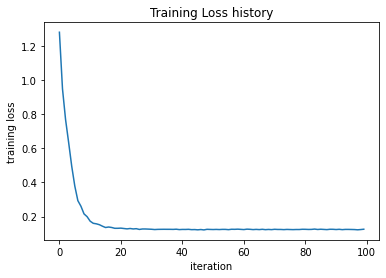

In [10]:
def init_toy_model_v4():
    np.random.seed(0)
    return TwoLayerNetv4(input_size, hidden_size, num_classes, std=1e-1)

net_v4 = init_toy_model_v4()
stats = net_v4.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

b) We are now ready to train our model on a real image dataset. For this, we will use
the CIFAR-10 dataset.  Since the images are of size $32\times 32$ pixels with 3
color channels, this gives us 3072 input layer units, represented by a vector
$x\in\mathbb{R}^{3072}$. The code to load the data and train the model is provided with
some default hyperparameters. With default
hyperparameters, if previous questions have been done correctly, you should get
a validation set accuracy of about 29\%. This is very poor.
Your task is to debug the model training and come up with better hyperparameters
to improve the performance on the validation set.
Visualize the training and validation performance curves to help with this analysis.
There are several pointers provided in the comments to 
help you understand why the network might be underperforming.
Once you have tuned your hyperparameters, and get validation accuracy greater
than 48\% run your best model on the test set once and report the performance.

**Download CIFAR-10 using this link: <http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz>**
<br />
**Decompress the downloaded dataset, and put the `cifar-10-batches-py` folder in the foleder `datasets`**

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


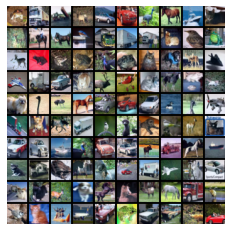

iteration 0 / 1000: loss 2.302647
iteration 100 / 1000: loss 2.302244
iteration 200 / 1000: loss 2.297334
iteration 300 / 1000: loss 2.259185
iteration 400 / 1000: loss 2.203392
iteration 500 / 1000: loss 2.117294
iteration 600 / 1000: loss 2.049749
iteration 700 / 1000: loss 1.986185
iteration 800 / 1000: loss 2.003852
iteration 900 / 1000: loss 1.948266
Validation accuracy:  0.287


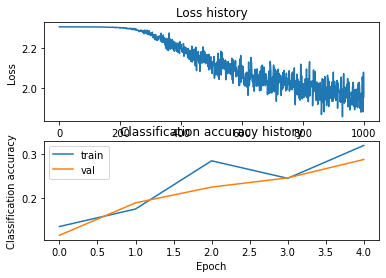

 Dummy code is complete


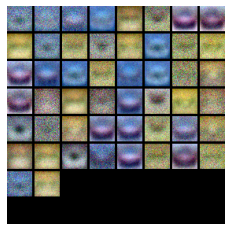

C:\Users\techn\AppData\Local\Temp/ipykernel_30400/1932283216.py:50: RuntimeWarning: divide by zero encountered in log
  loss += -np.log(scores[i, y[i]])
C:\Users\techn\AppData\Local\Temp/ipykernel_30400/2550019678.py:74: RuntimeWarning: overflow encountered in exp
  exp_z2 = np.exp(z2)
C:\Users\techn\AppData\Local\Temp/ipykernel_30400/2550019678.py:76: RuntimeWarning: invalid value encountered in true_divide
  scores = exp_z2/np.sum(exp_z2, axis=1).reshape(X.shape[0],1)


lr 1.000000e-04 reg 4.000000e-01 train accuracy: 0.286531 val accuracy: 0.276000
lr 1.000000e-04 reg 5.000000e-01 train accuracy: 0.283449 val accuracy: 0.285000
lr 1.000000e-04 reg 6.000000e-01 train accuracy: 0.282796 val accuracy: 0.283000
lr 1.000000e-03 reg 4.000000e-01 train accuracy: 0.479122 val accuracy: 0.463000
lr 1.000000e-03 reg 5.000000e-01 train accuracy: 0.482837 val accuracy: 0.461000
lr 1.000000e-03 reg 6.000000e-01 train accuracy: 0.474143 val accuracy: 0.456000
lr 1.000000e-02 reg 4.000000e-01 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-02 reg 5.000000e-01 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-02 reg 6.000000e-01 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved during cross-validation: 0.463000
iteration 0 / 20000: loss 1.434808
iteration 100 / 20000: loss 1.553045
iteration 200 / 20000: loss 1.350134
iteration 300 / 20000: loss 1.436217
iteration 400 / 20000: loss 1.440036
iteration 500 / 2000

iteration 19300 / 20000: loss 1.339582
iteration 19400 / 20000: loss 1.143628
iteration 19500 / 20000: loss 1.352392
iteration 19600 / 20000: loss 1.261929
iteration 19700 / 20000: loss 1.278279
iteration 19800 / 20000: loss 1.080881
iteration 19900 / 20000: loss 1.175476
Validation accuracy:  0.528


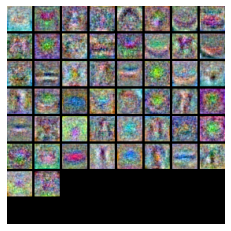

Test accuracy:  0.534


In [11]:
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

# # Load the data
# Now that you have implemented a two-layer network that passes
# gradient checks and works on toy data, it's time to load up our favorite
# CIFAR-10 data so we can use it to train a classifier on a real dataset.
# Invoke the get_CIFAR10_data function to get our data.

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Visualize some images to get a feel for the data
plt.imshow(visualize_grid(X_train[:100, :].reshape(100, 32,32, 3), padding=3).astype('uint8'))
plt.gca().axis('off')
plt.show()

# # Train a network
# To train our network we will use SGD. In addition, we will
# adjust the learning rate with an exponential learning rate schedule as
# optimization proceeds; after each epoch, we will reduce the learning rate by
# multiplying it by a decay rate.

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNetv4(input_size, hidden_size, num_classes)
# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# # Debug the training
# With the default parameters we provided above, you should get a validation
# accuracy of about 0.29 on the validation set. This isn't very good.
#
# One strategy for getting insight into what's wrong is to plot the loss
# function and the accuracies on the training and validation sets during
# optimization.
#
# Another strategy is to visualize the weights that were learned in the first
# layer of the network. In most neural networks trained on visual data, the
# first layer weights typically show some visible structure when visualized.

# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

print(" Dummy code is complete")
# Visualize the weights of the network

show_net_weights(net)

# # Tune your hyperparameters
#
# **What's wrong?**. Looking at the visualizations above, we see that the loss
# is decreasing more or less linearly, which seems to suggest that the learning
# rate may be too low. Moreover, there is no gap between the training and
# validation accuracy, suggesting that the model we used has low capacity, and
# that we should increase its size. On the other hand, with a very large model
# we would expect to see more overfitting, which would manifest itself as a
# very large gap between the training and validation accuracy.
#
# **Tuning**. Tuning the hyperparameters and developing intuition for how they
# affect the final performance is a large part of using Neural Networks, so we
# want you to get a lot of practice. Below, you should experiment with
# different values of the various hyperparameters, including hidden layer size,
# learning rate, numer of training epochs, and regularization strength. You
# might also consider tuning the learning rate decay, but you should be able to
# get good performance using the default value.
#
# **Approximate results**. You should be aim to achieve a classification
# accuracy of greater than 48% on the validation set. Our best network gets
# over 52% on the validation set.
#
# **Experiment**: You goal in this exercise is to get as good of a result on
# CIFAR-10 as you can (52% could serve as a reference), with a fully-connected
# Neural Network. Feel free implement your own techniques (e.g. PCA to reduce
# dimensionality, or adding dropout, or adding features to the solver, etc.).

# **Explain your hyperparameter tuning process in the report.**

best_net = None # store the best model into this

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
best_val = -1
best_stats = None
learning_rates = [1e-2, 1e-3, 1e-4]
regularization_strengths = [0.4, 0.5, 0.6]
results = {}
iters = 1000
for lr in learning_rates:
    for rs in regularization_strengths:
        net = TwoLayerNetv4(input_size, hidden_size, num_classes)

        # Train the network
        stats = net.train(X_train, y_train, X_val, y_val,
                    num_iters=iters, batch_size=200,
                    learning_rate=lr, learning_rate_decay=0.95,
                    reg=rs)

        y_train_pred = net.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = net.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)

        results[(lr, rs)] = (acc_train, acc_val)

        if best_val < acc_val:
            best_stats = stats
            best_val = acc_val
            best_net = net

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# visualize the weights of the best network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=20000, batch_size=200,
            learning_rate=0.7 * 1e-3, learning_rate_decay=0.90,
            reg=0.20, verbose=True)

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)
show_net_weights(best_net)


# # Run on the test set
# When you are done experimenting, you should evaluate your final trained
# network on the test set; you should get above 48%.

test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

### Question 4: Implement multi-layer perceptron using PyTorch library (10 points)

So far, we have implemented a two-layer network by explicitly writing down the expressions for the forward and backward computations and training algorithms using simple matrix multiplication primitives from the NumPy library.

However there are many libraries available designed make experimenting with neural networks faster by abstracting away the details into re-usable modules. One such popular open-source library is PyTorch (https://pytorch.org/). In this final question we will use the PyTorch library to implement the same two-layer network we did before and train it on the Cifar-10 dataset. However, extending a two-layer network to a three or four layered one is a matter of changing two-three lines of code using PyTorch. We will take advantage of this to experiment with deeper networks to improve the performance on the CIFAR-10 classification.

To install the pytorch library follow the instruction in
https://pytorch.org/get-started/locally/ . If you have access to a Graphics Processing
Unit (GPU), you can install the gpu verison and run the exercise on GPU for faster run
times. If not, you can install the cpu version (select cuda version None) and run on the
cpu. Having gpu access is not necessary to complete the exercise.  There are good tutorials
for getting started with pytorch on their website (https://pytorch.org/tutorials/).

a) Complete the code to implement a multi-layer perceptron network in the class
`MultiLayerPerceptron`. This includes instantiating the
required layers from `torch.nn` and writing the code for forward pass. Initially you 
should write the code for the same two-layer network we have seen before.
(3 points)

In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import sys
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
#hidden_size = [50]
hidden_size = [64,32]
num_classes = 10
num_epochs = 20
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 49000
num_validation =1000
train = True

#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
norm_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Using device: cuda


In [13]:
#======================================================================================
# Q4: Implementing multi-layer perceptron in PyTorch
#======================================================================================
# So far we have implemented a two-layer network using numpy by explicitly
# writing down the forward computation and deriving and implementing the
# equations for backward computation. This process can be tedious to extend to
# large network architectures
#
# Popular deep-learining libraries like PyTorch and Tensorflow allow us to
# quickly implement complicated neural network architectures. They provide
# pre-defined layers which can be used as building blocks to define our
# network. They also enable automatic-differentiation, which allows us to
# define only the forward pass and let the libraries perform back-propagation
# using automatic differentiation.
#
# In this question we will implement a multi-layer perceptron using the PyTorch
# library.  Please complete the code for the MultiLayerPerceptron, training and
# evaluating the model. Once you can train the two layer model, experiment with
# adding more layers and
#--------------------------------------------------------------------------------------

#-------------------------------------------------
# Fully connected neural network with one hidden layer
#-------------------------------------------------
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the mlp with given layer   #
        # configuration. input_size --> hidden_layers[0] --> hidden_layers[1] .... -->  #
        # hidden_layers[-1] --> num_classes                                             #
        # Make use of linear and relu layers from the torch.nn module                   #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****       
        layers.append(nn.Flatten())
        layers.append(nn.Linear(input_size, hidden_layers[0], bias=True))
        for i in range(len(hidden_layers)):
            layers.append(nn.ReLU())
            in_layer = hidden_layers[i]
            if i == len(hidden_layers)-1: 
                out_layer = num_classes
            else:
                out_layer = hidden_layers[i+1]
            layers.append(nn.Linear(in_layer, out_layer, bias=True))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        # Note that you do not need to use the softmax operation at the end.            #
        # Softmax is only required for the loss computation and the criterion used below#
        # nn.CrossEntropyLoss() already integrates the softmax and the log loss together#
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return self.layers(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


model = MultiLayerPerceptron(input_size, hidden_size, num_classes).to(device)

b) Complete the code to train the network. Make use of the loss function `torch.nn.CrossEntropyLoss` to compute the loss and `loss.backward()` to compute the gradients. Once gradients are computed, `optimizer.step()` can be invoked to update the model. Your should be able to achieve similar performance ($>$ 48\% accuracy on the validation set) as in Q3. Report the final validation accuracy you achieve with a two-layer network. (3 points)

In [14]:
load_ext tensorboard

In [15]:
# Training
model.apply(weights_init)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)


for epoch in range(num_epochs):
    correct = 0
    total = 0
    training_loss = 0.0
    validation_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        #if(i<5):
        #     break
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        #################################################################################
        # TODO: Implement the training code                                             #
        # 1. Pass the images to the model                                               #
        # 2. Compute the loss using the output and the labels.                          #
        # 3. Compute gradients and update the model using the optimizer                 #
        # Use examples in https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = model(images)
      
        # Compute loss
        loss = criterion(outputs, labels)

        training_loss += loss.item()
        
        # Perform backward pass
        loss.backward()
      
        # Perform optimization
        optimizer.step()
        
        _,predicted=torch.max(outputs.data,1)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        if (i+1) % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    writer.add_scalar('Loss/Train', training_loss, epoch)
    print('Train accuracy is: {} %'.format(100 * correct / total))
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            ####################################################
            # TODO: Implement the evaluation code              #
            # 1. Pass the images to the model                  #
            # 2. Get the most confident predicted class        #
            ####################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
      
            # Perform forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)

            _,predicted=torch.max(outputs.data,1)

            validation_loss += loss.item()
    
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        writer.add_scalar('Loss/Validation', validation_loss, epoch)
        print('Validataion accuracy is: {} %'.format(100 * correct / total))

writer.close()
##################################################################################
# TODO: Now that you can train a simple two-layer MLP using above code, you can  #
# easily experiment with adding more layers and different layer configurations   #
# and let the pytorch library handle computing the gradients                     #
#                                                                                #
# Experiment with different number of layers (atleast from 2 to 5 layers) and    #
# record the final validation accuracies Report your observations on how adding  #
# more layers to the MLP affects its behavior. Try to improve the model          #
# configuration using the validation performance as the guidance. You can        #
# experiment with different activation layers available in torch.nn, adding      #
# dropout layers, if you are interested. Use the best model on the validation    #
# set, to evaluate the performance on the test set once and report it            #
##################################################################################

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

# Run the test code once you have your by setting train flag to false
# and loading the best model

best_model = None # torch.load()
best_model = torch.load('model.ckpt')
model.load_state_dict(best_model)
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        ####################################################
        # TODO: Implement the evaluation code              #
        # 1. Pass the images to the model                  #
        # 2. Get the most confident predicted class        #
        ####################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        outputs = model(images)
        _,predicted=torch.max(outputs.data,1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

Epoch [1/20], Step [10/245], Loss: 2.2900
Epoch [1/20], Step [20/245], Loss: 2.2217
Epoch [1/20], Step [30/245], Loss: 2.1554
Epoch [1/20], Step [40/245], Loss: 2.0506
Epoch [1/20], Step [50/245], Loss: 2.0501
Epoch [1/20], Step [60/245], Loss: 2.0473
Epoch [1/20], Step [70/245], Loss: 2.0486
Epoch [1/20], Step [80/245], Loss: 2.0783
Epoch [1/20], Step [90/245], Loss: 1.9961
Epoch [1/20], Step [100/245], Loss: 2.0097
Epoch [1/20], Step [110/245], Loss: 1.9068
Epoch [1/20], Step [120/245], Loss: 1.9633
Epoch [1/20], Step [130/245], Loss: 1.9888
Epoch [1/20], Step [140/245], Loss: 1.8844
Epoch [1/20], Step [150/245], Loss: 1.9387
Epoch [1/20], Step [160/245], Loss: 1.8537
Epoch [1/20], Step [170/245], Loss: 1.8952
Epoch [1/20], Step [180/245], Loss: 1.8735
Epoch [1/20], Step [190/245], Loss: 1.8724
Epoch [1/20], Step [200/245], Loss: 1.8658
Epoch [1/20], Step [210/245], Loss: 1.7924
Epoch [1/20], Step [220/245], Loss: 1.7895
Epoch [1/20], Step [230/245], Loss: 1.7901
Epoch [1/20], Step [

Epoch [8/20], Step [140/245], Loss: 1.3308
Epoch [8/20], Step [150/245], Loss: 1.2624
Epoch [8/20], Step [160/245], Loss: 1.2885
Epoch [8/20], Step [170/245], Loss: 1.2811
Epoch [8/20], Step [180/245], Loss: 1.3705
Epoch [8/20], Step [190/245], Loss: 1.4012
Epoch [8/20], Step [200/245], Loss: 1.3177
Epoch [8/20], Step [210/245], Loss: 1.4121
Epoch [8/20], Step [220/245], Loss: 1.3261
Epoch [8/20], Step [230/245], Loss: 1.3601
Epoch [8/20], Step [240/245], Loss: 1.2705
Train accuracy is: 52.953061224489794 %
Validataion accuracy is: 51.6 %
Epoch [9/20], Step [10/245], Loss: 1.2628
Epoch [9/20], Step [20/245], Loss: 1.3535
Epoch [9/20], Step [30/245], Loss: 1.3185
Epoch [9/20], Step [40/245], Loss: 1.3278
Epoch [9/20], Step [50/245], Loss: 1.3254
Epoch [9/20], Step [60/245], Loss: 1.1950
Epoch [9/20], Step [70/245], Loss: 1.2662
Epoch [9/20], Step [80/245], Loss: 1.3600
Epoch [9/20], Step [90/245], Loss: 1.2913
Epoch [9/20], Step [100/245], Loss: 1.2488
Epoch [9/20], Step [110/245], Loss

Epoch [15/20], Step [240/245], Loss: 1.1268
Train accuracy is: 57.820408163265306 %
Validataion accuracy is: 53.3 %
Epoch [16/20], Step [10/245], Loss: 1.2082
Epoch [16/20], Step [20/245], Loss: 1.2972
Epoch [16/20], Step [30/245], Loss: 1.1462
Epoch [16/20], Step [40/245], Loss: 1.1087
Epoch [16/20], Step [50/245], Loss: 1.1410
Epoch [16/20], Step [60/245], Loss: 1.0610
Epoch [16/20], Step [70/245], Loss: 1.1593
Epoch [16/20], Step [80/245], Loss: 1.2773
Epoch [16/20], Step [90/245], Loss: 1.1975
Epoch [16/20], Step [100/245], Loss: 1.1270
Epoch [16/20], Step [110/245], Loss: 1.1572
Epoch [16/20], Step [120/245], Loss: 1.1207
Epoch [16/20], Step [130/245], Loss: 1.1965
Epoch [16/20], Step [140/245], Loss: 1.2491
Epoch [16/20], Step [150/245], Loss: 1.1186
Epoch [16/20], Step [160/245], Loss: 1.0886
Epoch [16/20], Step [170/245], Loss: 1.1661
Epoch [16/20], Step [180/245], Loss: 1.2277
Epoch [16/20], Step [190/245], Loss: 1.0680
Epoch [16/20], Step [200/245], Loss: 1.1806
Epoch [16/20]

In [16]:
tensorboard --logdir=runs

Final validation accuracy achieved with a two-layer network is 52.5 %.
We tried the following other networks hyperparameters:

<table>
<thead>
<tr>
<th>Layers</th>
<th>Activation Function</th>
<th>Learning rate</th>
<th>Validation</th>
</tr>
</thead>
<tbody>
<tr>
<td>2 [50,10]</td>
<td>ReLU</td>
<td>1e-3</td>
<td>52.5 %</td>
</tr>
<tr>
<td>3 [64,32,10]</td>
<td>ReLU</td>
<td>1e-3</td>
<td>53.9 %</td>
</tr>
<tr>
<td>4 [128,64,32,10]</td>
<td>ReLU</td>
<td>1e-3</td>
<td>7.8 %</td>
</tr>
<tr>
<td>4 [64,32,16,10]</td>
<td>ReLU</td>
<td>1e-3</td>
<td>7.8 %</td>
</tr>
<tr>
<td>5 [128,64,32,16,10]</td>
<td>ReLU</td>
<td>1e-3</td>
<td>7.9 %</td>
</tr>   
<td>2 [50,10]</td>
<td>LeakyReLU(0.1)</td>
<td>1e-3</td>
<td>51.5 %</td>
</tr>
<tr>    
<td>3 [64,32,10]</td>
<td>LeakyReLU(0.1)</td>
<td>1e-3</td>
<td>52.5 %</td>
</tr>
<tr>    
<td>3 [64,32,10]</td>
<td>tanh</td>
<td>1e-3</td>
<td>48 %</td>
</tr>
<tr>    
<td>3 [64,32,10]</td>
<td>tanh</td>
<td>1e-2</td>
<td>42.7 %</td>
</tr>
</tbody>
</table>

The best model with highest validation score(53.9%) is 3 layered network [64,32,10] with Activation Function = ReLU and learning rate = 1e-3. The test accuracy for this network is 53.7%.